“Gradient” approaches : define the brain as a set of continuous scores along manifold axes (≠ parcellisation into distinct areas based on anatomical functions or features)

Core gradient technique : 
1. **computation of an affinity matrix** that captures inter-area similarity of a given feature 
2. application of **dimensionality reduction** method (here diffusion embedding) to identify a gradual ordering of the input matrix in a lower dimensional manifold space.





Ressources 

- https://brainspace.readthedocs.io/en/latest/pages/install.html
- https://brainspace.readthedocs.io/en/latest/pages/getting_started.html

In [64]:
!git clone https://github.com/MICA-MNI/BrainSpace.git
!pip install load_confounds
!pip install vtk
!pip install "nilearn>=0.9.0"

%cd BrainSpace
!python setup.py install

import sys, os
import numpy as np
import nibabel as nib
import brainspace
import matplotlib
import sklearn

Clonage dans 'BrainSpace'...
remote: Enumerating objects: 4328, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 4328 (delta 203), reused 338 (delta 160), pack-reused 3905
Réception d'objets: 100% (4328/4328), 157.11 Mio | 14.76 Mio/s, fait.
Résolution des deltas: 100% (2642/2642), fait.
Mise à jour des fichiers: 100% (357/357), fait.
/home/romy.beaute/projects/hypnomed/code/BrainSpace/BrainSpace
/home/romy.beaute/anaconda3/lib/python3.9/site-packages/setuptools/dist.py:757: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
running install
/home/romy.beaute/anaconda3/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/romy.beaute/anaconda3/lib/python3.9

## Import the dataset as timeseries


NB : Timeseries (data) should be a numpy array with the dimensions: nodes x timepoints

In [65]:
sys.path.append('/mnt/data/romy/hypnomed/git/diffusion_embedding/scripts_reordered') 

from load_fs import *

sub = 'sub-01'
ses = 'ses-001'
state = 'rs_run-1'

freesurfer_output = '/mnt/data/romy/hypnomed/MRI_raw/BIDS/derivatives/fmriprep-latest/sourcedata/freesurfer'
vol2surf_path = "/mnt/data/romy/hypnomed/git/diffusion_embedding/vol2surf_derivatives/{}/{}".format(sub,ses)
labels = []
timeseries = [None] * 2

for i, h in enumerate(['lh', 'rh']):
    filename = os.path.join(vol2surf_path,'{}_{}_task-{}.fsa5.{}.mgz'.format(sub,ses,state,h))
    timeseries[i] = nib.load(filename.format(h)).get_fdata().squeeze()
    print(timeseries[i].shape) 
    labels.append(nib.freesurfer.read_label(f'{freesurfer_output}/fsaverage5/label/{h}.cortex.label'))
timeseries = np.vstack(timeseries)

print(' - Original shape timeseries : {} --> ie {} nodes x {} timepoints'.format(timeseries.shape,timeseries.shape[0],timeseries.shape[1]))
print(' - Label R + Label L : {} + {} nodes = {} nodes '.format(len(labels[0]),len(labels[1]),len(labels[0])+len(labels[1])))

(10242, 235)
(10242, 235)
 - Original shape timeseries : (20484, 235) --> ie 20484 nodes x 235 timepoints
 - Label R + Label L : 9354 + 9361 nodes = 18715 nodes 


*Compare wih shape from data loaded in tuto*

In [66]:
from brainspace.datasets import fetch_timeseries_preprocessing
ts_tuto = fetch_timeseries_preprocessing()
ts_tuto.shape

(20484, 652)

## Confound regression


Strategy to select and load confounds from fMRIPrep (based on past literature with limited parameters for user customisation).

=> use "simple" preset denoising strategy (as denoising strategy commonly used in resting state functional connectivity)
=> use global signal regression method to remove confounds without compromising the temporal degrees of freedom.
=> n = 33 regressors

Also compare with ICA-AROMA strategy (n=9 regressors)


Returns : 
1. counfounds -> n_cols = labels of the n regressors used based on the selected strategy
2. sample_mask (we have None in our case, ie no volume requires removal)


- https://nilearn.github.io/stable/modules/generated/nilearn.interfaces.fmriprep.load_confounds_strategy.html (COUFOUNDS Nilearn)
- https://nilearn.github.io/stable/glossary.html#term-fMRIPrep (fMRIPREP)
- https://fmriprep.org/en/latest/workflows.html#ica-aroma (ICA-AROMA)
- https://github.com/nipreps/fmriprep-notebooks/ (Discussion ICA-AROMA)


In [67]:
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn import signal

fmriprep_output = '/mnt/data/romy/hypnomed/MRI_raw/BIDS/derivatives/fmriprep-latest/{}/ses-001/func'.format(sub)

# Compare 2 types of confounds strategy
fmriprep_simple = '{}_ses-001_task-{}_space-T1w_desc-preproc_bold.nii.gz'.format(sub,state)
fmriprep_aroma = '{}_ses-001_task-{}_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'.format(sub,state)

Simple strategy

In [68]:
confounds_out_simple = load_confounds_strategy(os.path.join(fmriprep_output,fmriprep_simple),
                                        denoise_strategy='simple')[0]

print(confounds_out_simple.shape) #(n_timepoints,n_regressor_features)
print('n = {} regressors : {}'.format(confounds_out_simple.shape[1],confounds_out_simple.columns.tolist()))
confounds_out_simple

(235, 33)
n = 33 regressors : ['cosine00', 'cosine01', 'cosine02', 'cosine03', 'cosine04', 'cosine05', 'cosine06', 'csf', 'rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2', 'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2', 'trans_x', 'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2', 'trans_y', 'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2', 'trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2', 'white_matter']


,cosine00,cosine01,cosine02,cosine03,cosine04,cosine05,cosine06,csf,rot_x,rot_x_derivative1,...,trans_x_power2,trans_y,trans_y_derivative1,trans_y_derivative1_power2,trans_y_power2,trans_z,trans_z_derivative1,trans_z_derivative1_power2,trans_z_power2,white_matter
0,0.092251,0.092245,0.092235,0.092220,0.092202,0.092179,0.092152,211.381513,0.023669,0.000056,...,-0.111850,-0.046145,0.024992,0.000136,0.002945,0.050773,0.040857,0.000374,-0.020487,41.268159
1,0.092235,0.092179,0.092086,0.091957,0.091790,0.091586,0.091346,54.460432,0.023546,0.000056,...,-0.111438,-0.020865,0.024992,0.000136,-0.000085,0.090898,0.040857,0.000374,-0.024370,41.299174
2,0.092202,0.092047,0.091790,0.091430,0.090968,0.090405,0.089740,72.657765,0.023348,-0.000020,...,-0.111452,-0.014237,0.006341,-0.000459,-0.000668,0.070590,-0.019578,-0.000824,-0.022807,59.523952
3,0.092152,0.091849,0.091346,0.090642,0.089740,0.088642,0.087349,179.543399,0.023344,0.000175,...,-0.111848,-0.046187,-0.032238,0.000518,0.002951,0.049595,-0.020264,-0.000796,-0.020324,66.407435
4,0.092086,0.091586,0.090755,0.089595,0.088111,0.086309,0.084194,105.361708,0.023016,-0.000150,...,-0.111848,-0.000966,0.044933,0.001542,-0.001571,0.080438,0.031574,-0.000285,-0.023668,68.429112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,-0.092086,0.091586,-0.090755,0.089595,-0.088111,0.086309,-0.084194,-29.715734,-0.017700,-0.000052,...,0.118527,-0.006660,0.017184,-0.000198,-0.001227,-0.160498,0.064027,0.002770,0.053073,-34.161428
231,-0.092152,0.091849,-0.091346,0.090642,-0.089740,0.088642,-0.087349,-66.521009,-0.017884,-0.000006,...,0.118599,0.009142,0.015515,-0.000254,-0.002023,-0.121964,0.039265,0.000248,0.033000,-42.770629
232,-0.092202,0.092047,-0.091790,0.091430,-0.090968,0.090405,-0.089740,-99.798139,-0.017373,0.000690,...,0.107646,-0.023645,-0.033075,0.000572,0.000186,-0.190593,-0.067898,0.003473,0.070815,-44.753763
233,-0.092235,0.092179,-0.092086,0.091957,-0.091790,0.091586,-0.091346,-72.792664,-0.017844,-0.000292,...,0.094375,-0.019612,0.003745,-0.000487,-0.000202,-0.208576,-0.017252,-0.000913,0.082281,-42.383331


ICA-AROMA Strategy

In [69]:
confounds_out_AROMA = load_confounds_strategy(os.path.join(fmriprep_output,fmriprep_aroma),
                                        denoise_strategy='ica_aroma')[0]

print(confounds_out_AROMA.shape)
print('n = {} regressors : {}'.format(confounds_out_AROMA.shape[1],confounds_out_AROMA.columns.tolist()))
confounds_out_AROMA

(235, 9)
n = 9 regressors : ['cosine00', 'cosine01', 'cosine02', 'cosine03', 'cosine04', 'cosine05', 'cosine06', 'csf', 'white_matter']


,cosine00,cosine01,cosine02,cosine03,cosine04,cosine05,cosine06,csf,white_matter
0,0.092251,0.092245,0.092235,0.092220,0.092202,0.092179,0.092152,211.381513,41.268159
1,0.092235,0.092179,0.092086,0.091957,0.091790,0.091586,0.091346,54.460432,41.299174
2,0.092202,0.092047,0.091790,0.091430,0.090968,0.090405,0.089740,72.657765,59.523952
3,0.092152,0.091849,0.091346,0.090642,0.089740,0.088642,0.087349,179.543399,66.407435
4,0.092086,0.091586,0.090755,0.089595,0.088111,0.086309,0.084194,105.361708,68.429112
...,...,...,...,...,...,...,...,...,...
230,-0.092086,0.091586,-0.090755,0.089595,-0.088111,0.086309,-0.084194,-29.715734,-34.161428
231,-0.092152,0.091849,-0.091346,0.090642,-0.089740,0.088642,-0.087349,-66.521009,-42.770629
232,-0.092202,0.092047,-0.091790,0.091430,-0.090968,0.090405,-0.089740,-99.798139,-44.753763
233,-0.092235,0.092179,-0.092086,0.091957,-0.091790,0.091586,-0.091346,-72.792664,-42.383331


In [70]:
# Confound regression
clean_ts = signal.clean(timeseries.T, confounds=confounds_out_simple).T
clean_ts_AROMA = signal.clean(timeseries.T, confounds=confounds_out_AROMA).T
clean_ts.shape


(20484, 235)

*Compare wih shape from data loaded in tuto*

In [71]:
from brainspace.datasets import load_confounds_preprocessing
confounds_out_tuto = load_confounds_preprocessing()
confounds_out_tuto.shape

(652, 29)

## Extract the cleaned timeseries onto a set of labels

- https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_atlas_yeo_2011.html

Use Yeo Atlas & cortex atlas

- Yeo : ‘thick_7’: str, path to nifti file containing the 7 region parcellation fitted to thick template cortex segmentations. The image contains integer values which can be interpreted as the indices in colors_7.

In [72]:
label = nib.freesurfer.read_label(f'{freesurfer_output}/fsaverage5/label/{h}.cortex.label')

(256, 256, 256, 1)

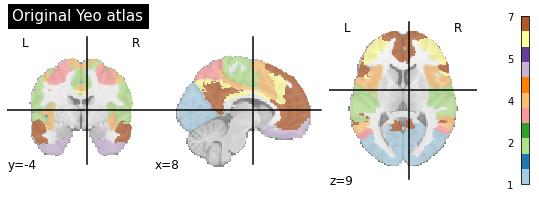

In [74]:
import numpy as np
from nilearn import datasets,plotting
from brainspace.utils.parcellation import reduce_by_labels
from nilearn.maskers import NiftiLabelsMasker


# Fetch surface atlas
atlas_destrieux = datasets.fetch_atlas_surf_destrieux()
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
atlas_yeo = atlas_yeo_2011.thick_7

# create masker to extract functional data within atlas parcels
masker_yeo = NiftiLabelsMasker(labels_img=atlas_yeo, standardize=True,
                           memory='nilearn_cache')

plotting.plot_roi(atlas_yeo, title='Original Yeo atlas',
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

lab_yeo = nib.load(atlas_yeo).get_fdata()
lab_yeo.shape

In [105]:
import numpy as np
from nilearn import datasets
from brainspace.utils.parcellation import reduce_by_labels

# Fetch surface atlas
atlas = datasets.fetch_atlas_surf_destrieux()
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011()
atlas_yeo = atlas_yeo_2011.thick_7
print(atlas_yeo)

# Remove non-cortex regions
regions = atlas['labels'].copy()
masked_regions = [b'Medial_wall', b'Unknown']
masked_labels = [regions.index(r) for r in masked_regions]
for r in masked_regions:
    regions.remove(r)

# Build Destrieux parcellation and mask
labeling = np.concatenate([atlas['map_left'], atlas['map_right']])
mask = ~np.isin(labeling, masked_labels)

# Distinct labels for left and right hemispheres
lab_lh = atlas['map_left']
labeling[lab_lh.size:] += lab_lh.max() + 1

# extract mean timeseries for each label
seed_ts = reduce_by_labels(clean_ts[mask], labeling[mask], axis=1, red_op='mean')
seed_ts.shape

/home/romy.beaute/nilearn_data/yeo_2011/Yeo_JNeurophysiol11_MNI152/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz


In [63]:
print(clean_ts.shape)

# data = np.vstack((clean_ts[0][labels[0],:],clean_ts[1][labels[1],:])) #concatenation 2 hemispheres (timeseries data)

lab_cortex = np.concatenate((labels[0],labels[1]))


data = np.vstack((clean_ts[:10242][labels[0],:],clean_ts[10242:][labels[1],:])) #concatenation 2 hemispheres (timeseries data)
data.shape

(20484, 235)


array([[-3.25195870e-01,  4.27141786e-01, -9.39830640e-01, ...,
        -2.37716603e+00, -1.42619746e+00, -7.13660027e-01],
       [-2.07124915e-01,  2.01434603e-01,  8.82214555e-03, ...,
         1.92499637e-01, -3.03719544e-01,  6.00205523e-02],
       [-1.37249793e-01, -4.91610752e-01, -1.29860365e-02, ...,
        -7.74682498e-01, -1.56427458e-01, -3.66725682e-04],
       ...,
       [-7.34307704e-01, -2.92774800e-01,  1.65061141e-01, ...,
        -1.22518338e+00, -4.39779765e-01,  1.81361186e-01],
       [-7.31511288e-01, -5.71370367e-01,  7.72536502e-02, ...,
        -1.70038937e+00, -5.08544896e-01,  1.82481503e-02],
       [-8.53889286e-01, -9.02568518e-01, -8.55604854e-02, ...,
        -1.99428963e+00, -5.62046891e-01, -3.02621673e-01]])

## Calculate functional connectivity matrix


- https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_group_level_connectivity.html

In [110]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')

correlation_matrix_data = correlation_measure.fit_transform([data.T])[0]
print(correlation_matrix_data.shape)


correlation_matrix_seed = correlation_measure.fit_transform([seed_ts.T])[0]
print(correlation_matrix_seed.shape)

(18715, 18715)
(148, 148)


ValueError: Labels are needed to show the reordering.

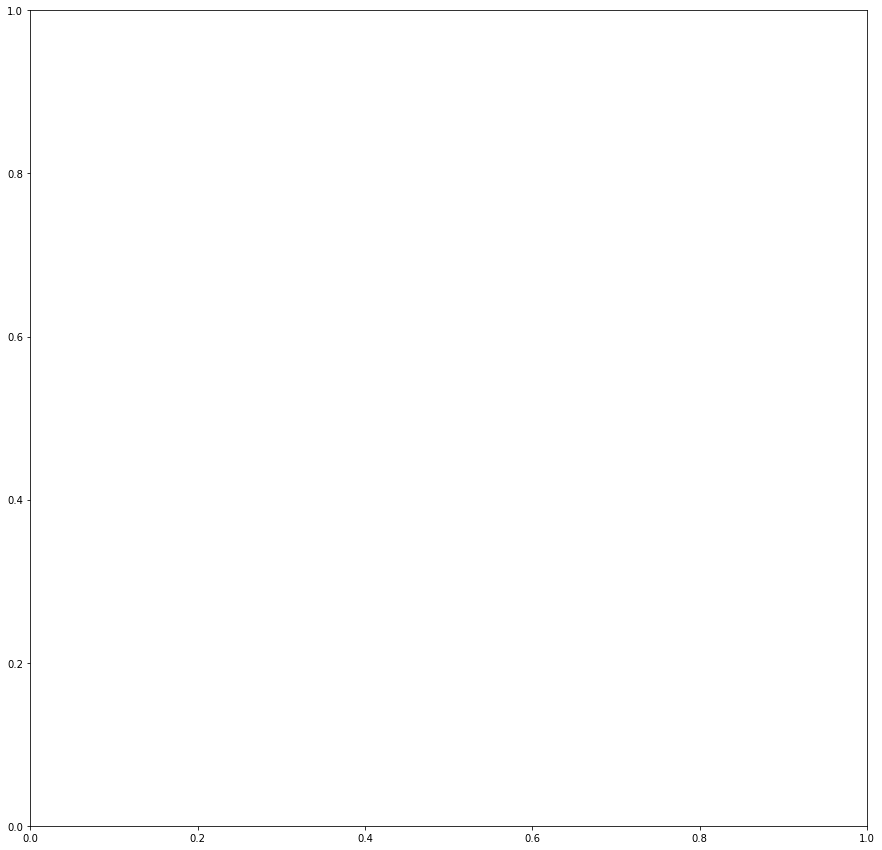

In [112]:
from nilearn import plotting

# Reduce matrix size, only for visualization purposes
mat_mask_data = np.where(np.std(correlation_matrix_data, axis=1) > 0.2)[0]
c_data = correlation_matrix_data[mat_mask_data][:, mat_mask_data]



# Reduce matrix size (SEED data), only for visualization purposes
mat_mask_seed = np.where(np.std(correlation_matrix_seed, axis=1) > 0.2)[0]
c_seed = correlation_matrix_seed[mat_mask_seed][:, mat_mask_seed]



# Create corresponding region names
regions_list = ['%s_%s' % (h, r.decode()) for h in ['L', 'R'] for r in regions]
masked_regions = [regions_list[i] for i in mat_mask_seed]


corr_plot = plotting.plot_matrix(c_seed, figure=(15, 15), labels=masked_regions,
                                 vmax=0.8, vmin=-0.8, reorder=True)

In [90]:
# Fetch surface atlas
atlas = datasets.fetch_atlas_surf_destrieux()
fsaverage = datasets.fetch_surf_fsaverage()

# Remove non-cortex regions
regions = atlas['labels'].copy()
fsaverage.keys()
fsaverage['infl_left']


[b'Unknown',
 b'G_and_S_frontomargin',
 b'G_and_S_occipital_inf',
 b'G_and_S_paracentral',
 b'G_and_S_subcentral',
 b'G_and_S_transv_frontopol',
 b'G_and_S_cingul-Ant',
 b'G_and_S_cingul-Mid-Ant',
 b'G_and_S_cingul-Mid-Post',
 b'G_cingul-Post-dorsal',
 b'G_cingul-Post-ventral',
 b'G_cuneus',
 b'G_front_inf-Opercular',
 b'G_front_inf-Orbital',
 b'G_front_inf-Triangul',
 b'G_front_middle',
 b'G_front_sup',
 b'G_Ins_lg_and_S_cent_ins',
 b'G_insular_short',
 b'G_occipital_middle',
 b'G_occipital_sup',
 b'G_oc-temp_lat-fusifor',
 b'G_oc-temp_med-Lingual',
 b'G_oc-temp_med-Parahip',
 b'G_orbital',
 b'G_pariet_inf-Angular',
 b'G_pariet_inf-Supramar',
 b'G_parietal_sup',
 b'G_postcentral',
 b'G_precentral',
 b'G_precuneus',
 b'G_rectus',
 b'G_subcallosal',
 b'G_temp_sup-G_T_transv',
 b'G_temp_sup-Lateral',
 b'G_temp_sup-Plan_polar',
 b'G_temp_sup-Plan_tempo',
 b'G_temporal_inf',
 b'G_temporal_middle',
 b'Lat_Fis-ant-Horizont',
 b'Lat_Fis-ant-Vertical',
 b'Lat_Fis-post',
 b'Medial_wall',
 b'Pol

## Run gradient analysis and visualize

In [113]:
from brainspace.gradient import GradientMaps

gm = GradientMaps(n_components=2, random_state=0)
gm.fit(correlation_matrix_seed)

/home/romy.beaute/projects/hypnomed/code/BrainSpace/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps(n_components=2, random_state=0)

In [114]:
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

# Map gradients to original parcels
grad = [None] * 2
for i, g in enumerate(gm.gradients_.T):
    grad[i] = map_to_labels(g, labeling, mask=mask, fill=np.nan)


# Load fsaverage5 surfaces
surf_lh, surf_rh = load_fsa5()

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1200, 400), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1', 'Grad2'], zoom=1.5)


/home/romy.beaute/projects/hypnomed/code/BrainSpace/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


: 

: 